# ***MARKET CLASSIFICATION MODEL***

This model will be used to classify the current market into three classes:
*   Buyers Market
*   Sellers Market
*   Even Market



# ***MARKET CLASSIFICATION MODEL FEATURES***

Notation:
*   (IMP): Important Feature

The following features will be used:
*   Activity Ratios (Quarterly):
    *   (IMP) New listings ratio: new_active_listings / total_properties
    *   (IMP) Absorption rate: closed_sales / active_listings
    *   (IMP) Pending conversion rate: pending_to_closed / total_pending
    *   Back-to-market rate: back_to_market / total_pending
    *   Off-market withdrawal rate: off_market / total_active
*   Velocity Metrics:
    *   Average days on market: sum(days_active) / closed_sales
    *   Pending duration: sum(days_pending) / closed_sales
    *   (IMP) Market turnover: total_status_changes / total_properties
*   Supply-Demand Indicators:
    *   Inventory months: active_listings / (closed_sales / 3_months)
    *   (IMP) Competition index: pending_listings / active_listings
    *   (IMP) Market pressure: (new_listings - closed_sales) / new_listings

# ***EXPLAINING THE VARIABLES***

**Activity Ratios**

*   **New Listings Ratio:** new_active_listings / total_properties

    **Variables:**
      *   *new_active_listings:* Count of properties that entered "Active" status for the first time during the quarter
      *   *total_properties:* Total unique properties with any activity in the quarter

    **Purpose:** Measures fresh inventory entering the market relative to overall market size

    <br>

*   **Absorption Rate:** closed_sales / active_listings

    **Variables:**
      *   *closed_sales:* Number of properties that changed from any status to "Closed" during the quarter
      *   *active_listings:* Average number of properties in "Active" status during the quarter

    **Purpose:** Indicates how quickly the market absorbs available inventory
    
    <br>

*   **Pending Conversion Rate:** pending_to_closed / total_pending

    **Variables:**
      *   *pending_to_closed:* Properties that successfully moved from "Pending" to "Closed" status
      *   *total_pending:* All properties that were in "Pending" status at any point during the quarter

    **Purpose:** Measures deal completion success rate

    <br>

*   **Back-to-Market Rate:** back_to_market / total_pending

    **Variables:**
      *   *back_to_market:* Properties that moved from "Pending" back to "Active" status (failed deals)
      *   *total_pending:* All properties that were in "Pending" status at any point during the quarter

    **Purpose:** Indicates market instability and deal failure rates

    <br>

*   **Off-Market Withdrawal Rate:** off_market / total_active

    **Variables:**
      *   *off_market:* Properties that moved from "Active" to "Off Market" status (withdrawn without selling)
      *   *total_active:* Total properties that were active during the quarter

    **Purpose:** Shows seller confidence in the current market conditions

    <br>

**Velocity Metrics**

*   **Average Days on Market:** sum(days_active) / closed_sales

    **Variables:**
      *   *days_active:* total days properties spent in "Active" status before selling
      *   *closed_sales:* Number of properties that successfully closed

    **Purpose:** Measures how quickly properties sell, indicating market heat

    <br>

*   **Pending Duration:** sum(days_pending) / closed_sales

    **Variables:**
      *   *days_pending:* Total days properties spent in "Pending" status before closing
      *   *closed_sales:* Number of properties that successfully closed

    **Purpose:** Indicates transaction complexity and financing conditions

    <br>

*   **Market Turnover:** total_status_changes / total_properties

    **Variables:**
      *   *total_status_changes:* Sum of all status transitions (Active→Pending, Pending→Closed, etc.)
      *   *total_properties:* Total unique properties in the dataset

    **Purpose:** Measures overall market activity and dynamism

    <br>

**Supply-Demand Indicators**
*   **Inventory Months:** active_listings / (closed_sales / 3_months)

    **Variables:**
      *   *active_listings:* Current count of properties in "Active" status at quarter-end
      *   *closed_sales:* Number of sales completed in the quarter
      *   *3_months:* equals 3

    **Purpose:** Shows how many months it would take to sell current inventory at current pace

    <br>

*   **Competition Index:** pending_listings / active_listings

    **Variables:**
      *   *pending_listings:* Properties currently in "Pending" status
      *   *active_listings:* Properties currently in "Active" status

    **Purpose:** Indicates buyer competition intensity

    <br>

*   **Market Pressure:** (new_listings - closed_sales) / new_listings

    **Variables:**
      *   *new_listings:* Properties newly entered to market during quarter
      *   *closed_sales:* Properties that closed during quarter

    **Purpose:** Shows whether supply is increasing or decreasing relative to demand

    <br>

**Notes:**

Transitions
*   **Active→Pending:** Properties moving under contract
*   **Pending→Closed:** Successful transactions
*   **Pending→Active:** Failed contracts returning to market
*   **Active→Off Market:** Withdrawn listings
*   **Off Market→Active:** Re-listed properties

These transitions are counted and timed to create velocity and success rate metrics.
We are using only the most recent quarterly periods so we could use rolling averages to include the older quarterlies values in the decision making while giving them less importance.

# ***CREATING THE MODEL***

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shap
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [29]:
class EnhancedHousingMarketPredictor:
    """
    Enhanced XGBoost model with comprehensive feature-target relationship visualizations
    """

    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = []
        self.is_fitted = False
        self.X_train = None
        self.y_train = None
        self.market_labels = ['Buyers Market', 'Even Market', 'Sellers Market']

    def create_sample_data(self, n_samples=2000):
        """Generate realistic sample housing market data"""
        np.random.seed(42)

        data = {}
        market_conditions = np.random.choice([0, 1, 2], n_samples, p=[0.3, 0.4, 0.3])

        for i in range(n_samples):
            condition = market_conditions[i]

            if condition == 0:  # Buyers Market
                active_listings = np.random.normal(500, 100)
                closed_sales = np.random.normal(80, 20)
                days_on_market = np.random.normal(45, 15)
                pending_conversion = np.random.normal(0.75, 0.1)
                back_to_market_rate = np.random.normal(0.15, 0.05)

            elif condition == 1:  # Even Market
                active_listings = np.random.normal(300, 50)
                closed_sales = np.random.normal(100, 15)
                days_on_market = np.random.normal(30, 10)
                pending_conversion = np.random.normal(0.85, 0.05)
                back_to_market_rate = np.random.normal(0.08, 0.03)

            else:  # Sellers Market
                active_listings = np.random.normal(150, 30)
                closed_sales = np.random.normal(120, 25)
                days_on_market = np.random.normal(15, 8)
                pending_conversion = np.random.normal(0.95, 0.03)
                back_to_market_rate = np.random.normal(0.03, 0.02)

            # Ensure positive values
            active_listings = max(50, active_listings)
            closed_sales = max(10, closed_sales)
            days_on_market = max(5, days_on_market)
            pending_conversion = np.clip(pending_conversion, 0.5, 1.0)
            back_to_market_rate = np.clip(back_to_market_rate, 0.01, 0.3)

            # Calculate derived features
            total_properties = active_listings + closed_sales + np.random.normal(50, 20)
            total_properties = max(100, total_properties)

            pending_listings = np.random.normal(closed_sales * 0.3, 10)
            pending_listings = max(5, pending_listings)

            new_listings = np.random.normal(closed_sales * 1.2, 20)
            new_listings = max(20, new_listings)

            off_market = np.random.normal(active_listings * 0.1, 5)
            off_market = max(1, off_market)

            data[i] = {
                'active_listings': active_listings,
                'closed_sales': closed_sales,
                'pending_listings': pending_listings,
                'new_listings': new_listings,
                'off_market': off_market,
                'total_properties': total_properties,
                'days_on_market': days_on_market,
                'pending_conversion_rate': pending_conversion,
                'back_to_market_rate': back_to_market_rate,
                'market_condition': condition
            }

        return pd.DataFrame.from_dict(data, orient='index')

    def engineer_features(self, df):
        """Create all the features for market prediction"""
        features_df = df.copy()

        # Activity Ratios
        features_df['new_listings_ratio'] = features_df['new_listings'] / features_df['total_properties']
        features_df['absorption_rate'] = features_df['closed_sales'] / features_df['active_listings']
        features_df['off_market_rate'] = features_df['off_market'] / features_df['active_listings']

        # Velocity Metrics
        features_df['market_turnover'] = (features_df['closed_sales'] + features_df['pending_listings']) / features_df['total_properties']
        features_df['pending_duration'] = features_df['days_on_market'] * 0.3

        # Supply-Demand Indicators
        features_df['inventory_months'] = features_df['active_listings'] / (features_df['closed_sales'] / 3)
        features_df['competition_index'] = features_df['pending_listings'] / features_df['active_listings']
        features_df['market_pressure'] = (features_df['new_listings'] - features_df['closed_sales']) / features_df['new_listings']

        # Market Heat Score
        features_df['market_heat_score'] = (
            (1 / features_df['inventory_months']) * 0.3 +
            features_df['absorption_rate'] * 0.25 +
            (1 / features_df['days_on_market']) * 0.2 +
            features_df['pending_conversion_rate'] * 0.15 +
            (1 - features_df['back_to_market_rate']) * 0.1
        )

        # Price Momentum Indicators
        features_df['price_momentum'] = np.where(
            features_df['market_heat_score'] > features_df['market_heat_score'].median(),
            np.random.normal(1.05, 0.1, len(features_df)),
            np.random.normal(0.98, 0.08, len(features_df))
        )

        # Market Efficiency Metrics
        features_df['listing_efficiency'] = features_df['closed_sales'] / features_df['new_listings']
        features_df['market_velocity'] = features_df['total_properties'] / features_df['days_on_market']

        # Handle infinite and NaN values
        features_df = features_df.replace([np.inf, -np.inf], np.nan)
        features_df = features_df.fillna(features_df.median())

        return features_df

    def prepare_features(self, df):
        """Select and prepare final feature set for modeling"""
        feature_columns = [
            'new_listings_ratio', 'absorption_rate', 'off_market_rate',
            'market_turnover', 'pending_duration', 'inventory_months',
            'competition_index', 'market_pressure', 'market_heat_score',
            'price_momentum', 'listing_efficiency', 'market_velocity',
            'days_on_market', 'pending_conversion_rate', 'back_to_market_rate'
        ]

        self.feature_names = feature_columns
        return df[feature_columns]

    def fit(self, X, y, optimize_hyperparameters=False):
        """Train the XGBoost model"""
        print("🚀 Training Enhanced XGBoost Housing Market Prediction Model...")

        # Store training data for visualizations
        self.X_train = X.copy()
        self.y_train = y.copy()

        # Split data for validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)

        if optimize_hyperparameters:
            print("🔧 Optimizing hyperparameters...")
            param_grid = {
                'n_estimators': [100, 200],
                'max_depth': [4, 6],
                'learning_rate': [0.1, 0.2],
                'subsample': [0.8, 0.9],
                'colsample_bytree': [0.8, 0.9]
            }

            xgb_model = xgb.XGBClassifier(
                objective='multi:softprob',
                num_class=3,
                random_state=42,
                n_jobs=-1
            )

            grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_train_scaled, y_train)
            self.model = grid_search.best_estimator_

        else:
            self.model = xgb.XGBClassifier(
                objective='multi:softprob',
                num_class=3,
                n_estimators=200,
                max_depth=4,
                learning_rate=0.1,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_alpha=0.1,
                reg_lambda=1.5,
                random_state=42,
                n_jobs=-1
            )

            self.model.fit(X_train_scaled, y_train)

        # Validate model
        val_predictions = self.model.predict(X_val_scaled)
        val_accuracy = accuracy_score(y_val, val_predictions)
        print(f"✅ Validation Accuracy: {val_accuracy:.4f}")

        self.is_fitted = True
        return self

    def plot_feature_importance_comprehensive(self):
        """
        Plot comprehensive feature importance analysis using multiple methods
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before plotting feature importance")

        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('Comprehensive Feature Importance Analysis', fontsize=20, fontweight='bold')

        # 1. Built-in XGBoost Feature Importance (Gain)
        importance_gain = self.model.get_booster().get_score(importance_type='gain')
        if importance_gain:
            gain_df = pd.DataFrame(list(importance_gain.items()), columns=['feature', 'importance'])
            gain_df = gain_df.sort_values('importance', ascending=True)

            axes[0][0].barh(gain_df['feature'], gain_df['importance'], color='skyblue')
            axes[0][0].set_title('XGBoost Feature Importance (Gain)', fontsize=14, fontweight='bold')
            axes[0][0].set_xlabel('Importance Score')

        # 2. Built-in XGBoost Feature Importance (Weight)
        importance_weight = self.model.get_booster().get_score(importance_type='weight')
        if importance_weight:
            weight_df = pd.DataFrame(list(importance_weight.items()), columns=['feature', 'importance'])
            weight_df = weight_df.sort_values('importance', ascending=True)

            axes[0][1].barh(weight_df['feature'], weight_df['importance'], color='lightcoral')
            axes[0][1].set_title('XGBoost Feature Importance (Weight)', fontsize=14, fontweight='bold')
            axes[0][1].set_xlabel('Importance Score')

        # 3. Scikit-learn Feature Importance
        feature_imp_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=True)

        axes[1][0].barh(feature_imp_df['feature'], feature_imp_df['importance'], color='lightgreen')
        axes[1][0].set_title('Scikit-learn Feature Importance', fontsize=14, fontweight='bold')
        axes[1][0].set_xlabel('Importance Score')

        # 4. Feature Importance Comparison
        if importance_gain and len(importance_gain) > 0:
            # Normalize all importance scores for comparison
            gain_norm = pd.Series(importance_gain).sort_index()
            weight_norm = pd.Series(importance_weight).sort_index() if importance_weight else pd.Series()
            sklearn_norm = pd.Series(self.model.feature_importances_, index=self.feature_names).sort_index()

            comparison_df = pd.DataFrame({
                'Gain': gain_norm,
                'Weight': weight_norm if not weight_norm.empty else np.zeros(len(gain_norm)),
                'Sklearn': sklearn_norm
            }).fillna(0)

            comparison_df.plot(kind='bar', ax=axes[1][1], width=0.8)
            axes[1][1].set_title('Feature Importance Comparison', fontsize=14, fontweight='bold')
            axes[1][1].set_xlabel('Features')
            axes[1][1].set_ylabel('Normalized Importance')
            axes[1][1].tick_params(axis='x', rotation=45)
            axes[1][1].legend()

        plt.tight_layout()
        plt.show()

        return feature_imp_df

    def plot_feature_distributions_by_class(self):
        """
        Plot feature distributions for each market class
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Training data not available. Fit the model first.")

        # Combine features and target
        plot_data = self.X_train.copy()
        plot_data['market_condition'] = self.y_train
        plot_data['market_type'] = plot_data['market_condition'].map({
            0: 'Sellers Market', 1: 'Even Market', 2: 'Buyers Market'
        })

        # Select top 8 most important features
        top_features = self.model.feature_importances_.argsort()[-8:][::-1]
        top_feature_names = [self.feature_names[i] for i in top_features]

        fig, axes = plt.subplots(4, 2, figsize=(20, 24))
        fig.suptitle('Feature Distributions by Market Type', fontsize=20, fontweight='bold')

        for idx, feature in enumerate(top_feature_names):
            row = idx // 2
            col = idx % 2

            # Box plot
            sns.boxplot(data=plot_data, x='market_type', y=feature, ax=axes[row, col])
            axes[row, col].set_title(f'{feature.replace("_", " ").title()}', fontsize=12, fontweight='bold')
            axes[row, col].tick_params(axis='x', rotation=45)

            # Add mean values as text
            for i, market in enumerate(['Sellers Market', 'Even Market', 'Buyers Market']):
                mean_val = plot_data[plot_data['market_type'] == market][feature].mean()
                axes[row, col].text(i, mean_val, f'{mean_val:.2f}',
                                  ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def plot_correlation_heatmap(self):
        """
        Plot correlation heatmap between features and target
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Training data not available. Fit the model first.")

        # Combine features and target
        corr_data = self.X_train.copy()
        corr_data['market_condition'] = self.y_train

        # Calculate correlation matrix
        correlation_matrix = corr_data.corr()

        # Create heatmap
        plt.figure(figsize=(16, 14))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

        sns.heatmap(correlation_matrix,
                   mask=mask,
                   annot=True,
                   cmap='RdYlBu_r',
                   center=0,
                   square=True,
                   fmt='.2f',
                   cbar_kws={"shrink": .8})

        plt.title('Feature Correlation Heatmap with Target Variable', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Show correlations with target specifically
        target_corr = correlation_matrix['market_condition'].drop('market_condition').sort_values(key=abs, ascending=False)

        plt.figure(figsize=(12, 8))
        colors = ['red' if x < 0 else 'green' for x in target_corr.values]
        bars = plt.barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.7)
        plt.yticks(range(len(target_corr)), [name.replace('_', ' ').title() for name in target_corr.index])
        plt.xlabel('Correlation with Market Condition')
        plt.title('Feature Correlation with Market Condition', fontsize=14, fontweight='bold')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

        # Add correlation values on bars
        for i, (bar, val) in enumerate(zip(bars, target_corr.values)):
            plt.text(val + (0.01 if val > 0 else -0.01), i, f'{val:.3f}',
                    va='center', ha='left' if val > 0 else 'right', fontweight='bold')

        plt.tight_layout()
        plt.show()

        return target_corr

    def plot_partial_dependence_plots(self, features_to_plot=None):
        """
        Create partial dependence plots for top features
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before creating partial dependence plots")

        if features_to_plot is None:
            # Select top 6 most important features
            top_indices = self.model.feature_importances_.argsort()[-6:][::-1]
            features_to_plot = [i for i in top_indices]

        # Scale the training data for PDP
        X_scaled = self.scaler.transform(self.X_train)

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Partial Dependence Plots - Feature Impact on Market Prediction', fontsize=16, fontweight='bold')

        for idx, feature_idx in enumerate(features_to_plot):
            row = idx // 3
            col = idx % 3

            # Calculate partial dependence
            pd_result = partial_dependence(
                self.model, X_scaled, [feature_idx],
                kind='average', grid_resolution=50
            )

            feature_name = self.feature_names[feature_idx]

            # Plot for each class
            for class_idx in range(3):
                axes[row, col].plot(pd_result['grid_values'][0],
                                  pd_result['average'][class_idx],
                                  label=self.market_labels[class_idx],
                                  linewidth=2)

            axes[row, col].set_xlabel(feature_name.replace('_', ' ').title())
            axes[row, col].set_ylabel('Partial Dependence')
            axes[row, col].set_title(f'PDP: {feature_name.replace("_", " ").title()}', fontweight='bold')
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_shap_analysis(self, sample_size=100):
        """
        Create SHAP (SHapley Additive exPlanations) analysis - FIXED VERSION
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before SHAP analysis")

        print("🔍 Generating SHAP Analysis (this may take a moment)...")

        # Sample data for SHAP analysis (to speed up computation)
        if len(self.X_train) > sample_size:
            sample_indices = np.random.choice(len(self.X_train), sample_size, replace=False)
            X_sample = self.X_train.iloc[sample_indices]
        else:
            X_sample = self.X_train

        X_sample_scaled = self.scaler.transform(X_sample)

        # Create SHAP explainer
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(X_sample_scaled)

        # Check the structure of shap_values
        print(f"SHAP values shape: {np.array(shap_values).shape}")

        # For multiclass classification, shap_values is a list of arrays
        # Each array corresponds to one class
        if isinstance(shap_values, list) and len(shap_values) == 3:
            print("✅ Detected multiclass SHAP values structure")

            # 1. Overall SHAP Summary Plot (all classes combined)
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_sample_scaled,
                            feature_names=self.feature_names,
                            class_names=self.market_labels,
                            show=False)
            plt.title('SHAP Summary Plot - All Market Types', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

            # 2. Individual class SHAP plots
            fig, axes = plt.subplots(1, 3, figsize=(24, 6))
            fig.suptitle('SHAP Summary Plots by Market Type', fontsize=16, fontweight='bold')

            for class_idx in range(3):
                plt.sca(axes[class_idx])

                # Use the specific class SHAP values
                shap.summary_plot(shap_values[class_idx], X_sample_scaled,
                                feature_names=self.feature_names,
                                show=False, plot_type='bar')
                axes[class_idx].set_title(f'{self.market_labels[class_idx]}', fontweight='bold')

            plt.tight_layout()
            plt.show()

            # 3. Feature importance comparison across classes
            self.plot_shap_feature_importance_comparison(shap_values, X_sample_scaled)

        else:
            # Fallback for unexpected SHAP structure
            print(f"⚠️ Unexpected SHAP values structure: {type(shap_values)}")
            if hasattr(shap_values, 'shape'):
                print(f"Shape: {shap_values.shape}")

            # Try to plot with the raw values
            plt.figure(figsize=(12, 8))
            try:
                shap.summary_plot(shap_values, X_sample_scaled,
                                feature_names=self.feature_names,
                                show=False)
                plt.title('SHAP Summary Plot', fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"❌ Could not create SHAP plot: {e}")
                return None

        return shap_values

    def plot_shap_feature_importance_comparison(self, shap_values, X_sample_scaled):
        """
        Compare feature importance across different market classes using SHAP
        """
        # Calculate mean absolute SHAP values for each class
        class_importance = {}

        for class_idx in range(3):
            # Mean absolute SHAP values for this class
            mean_abs_shap = np.mean(np.abs(shap_values[class_idx]), axis=0)
            class_importance[self.market_labels[class_idx]] = mean_abs_shap

        # Create DataFrame for comparison
        importance_df = pd.DataFrame(class_importance, index=self.feature_names)

        # Plot comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Stacked bar chart
        importance_df.plot(kind='bar', stacked=True, ax=ax1, width=0.8)
        ax1.set_title('SHAP Feature Importance by Market Type (Stacked)', fontweight='bold')
        ax1.set_xlabel('Features')
        ax1.set_ylabel('Mean |SHAP Value|')
        ax1.tick_params(axis='x', rotation=45)
        ax1.legend(title='Market Type')

        # Grouped bar chart
        importance_df.plot(kind='bar', ax=ax2, width=0.8)
        ax2.set_title('SHAP Feature Importance by Market Type (Grouped)', fontweight='bold')
        ax2.set_xlabel('Features')
        ax2.set_ylabel('Mean |SHAP Value|')
        ax2.tick_params(axis='x', rotation=45)
        ax2.legend(title='Market Type')

        plt.tight_layout()
        plt.show()

        return importance_df

    def plot_shap_waterfall_examples(self, sample_size=3):
        """
        Create SHAP waterfall plots for individual predictions
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before SHAP analysis")

        # Get a few sample predictions
        sample_indices = np.random.choice(len(self.X_train), sample_size, replace=False)
        X_sample = self.X_train.iloc[sample_indices]
        X_sample_scaled = self.scaler.transform(X_sample)

        # Create SHAP explainer
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(X_sample_scaled)

        # Get predictions
        predictions = self.model.predict(X_sample_scaled)
        probabilities = self.model.predict_proba(X_sample_scaled)

        # Create waterfall plots for each sample
        fig, axes = plt.subplots(sample_size, 1, figsize=(15, 6*sample_size))
        if sample_size == 1:
            axes = [axes]

        fig.suptitle('SHAP Waterfall Plots - Individual Predictions', fontsize=16, fontweight='bold')

        for i in range(sample_size):
            predicted_class = predictions[i]
            confidence = probabilities[i][predicted_class]

            # Use SHAP values for the predicted class
            if isinstance(shap_values, list):
                sample_shap_values = shap_values[predicted_class][i]
            else:
                sample_shap_values = shap_values[i]

            # Create waterfall plot manually since shap.waterfall_plot might not work
            feature_contributions = list(zip(self.feature_names, sample_shap_values))
            feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

            # Plot top 10 features
            top_features = feature_contributions[:10]
            features, values = zip(*top_features)

            colors = ['red' if v < 0 else 'green' for v in values]
            bars = axes[i].barh(range(len(features)), values, color=colors, alpha=0.7)

            axes[i].set_yticks(range(len(features)))
            axes[i].set_yticklabels([f.replace('_', ' ').title() for f in features])
            axes[i].set_xlabel('SHAP Value')
            axes[i].set_title(f'Sample {i+1}: Predicted {self.market_labels[predicted_class]} (Confidence: {confidence:.2%})')
            axes[i].axvline(x=0, color='black', linestyle='-', alpha=0.3)

            # Add value labels on bars
            for bar, val in zip(bars, values):
                axes[i].text(val + (0.001 if val > 0 else -0.001), bar.get_y() + bar.get_height()/2,
                            f'{val:.3f}', va='center', ha='left' if val > 0 else 'right', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def plot_feature_interaction_analysis(self):
        """
        Analyze and visualize feature interactions
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Training data not available. Fit the model first.")

        # Select top 5 features for interaction analysis
        top_features_idx = self.model.feature_importances_.argsort()[-5:][::-1]
        top_features = [self.feature_names[i] for i in top_features_idx]

        # Create interaction plots
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Feature Interaction Analysis', fontsize=16, fontweight='bold')

        plot_data = self.X_train[top_features].copy()
        plot_data['market_condition'] = self.y_train
        plot_data['market_type'] = plot_data['market_condition'].map({
            0: 'Sellers Market', 1: 'Even Market', 2: 'Buyers Market'
        })

        # Create scatter plots for feature pairs
        feature_pairs = [
            (top_features[0], top_features[1]),
            (top_features[0], top_features[2]),
            (top_features[1], top_features[2]),
            (top_features[0], top_features[3]),
            (top_features[1], top_features[3]),
            (top_features[2], top_features[3])
        ]

        for idx, (feat1, feat2) in enumerate(feature_pairs):
            row = idx // 3
            col = idx % 3

            for market_type in ['Sellers Market', 'Even Market', 'Buyers Market']:
                market_data = plot_data[plot_data['market_type'] == market_type]
                axes[row, col].scatter(market_data[feat1], market_data[feat2],
                                     label=market_type, alpha=0.6, s=30)

            axes[row, col].set_xlabel(feat1.replace('_', ' ').title())
            axes[row, col].set_ylabel(feat2.replace('_', ' ').title())
            axes[row, col].set_title(f'{feat1.replace("_", " ").title()} vs {feat2.replace("_", " ").title()}')
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def create_comprehensive_analysis_report(self):
        """
        Generate a comprehensive analysis report with all visualizations - UPDATED
        """
        print("📊 Generating Comprehensive Feature-Target Relationship Analysis")
        print("=" * 70)

        # 1. Feature Importance Analysis
        print("\n1️⃣ Feature Importance Analysis")
        feature_imp_df = self.plot_feature_importance_comprehensive()

        # 2. Feature Distributions by Class
        print("\n2️⃣ Feature Distributions by Market Type")
        self.plot_feature_distributions_by_class()

        # 3. Correlation Analysis
        print("\n3️⃣ Correlation Analysis")
        target_corr = self.plot_correlation_heatmap()

        # 4. Partial Dependence Plots
        print("\n4️⃣ Partial Dependence Analysis")
        self.plot_partial_dependence_plots()

        # 5. Feature Interactions
        print("\n5️⃣ Feature Interaction Analysis")
        self.plot_feature_interaction_analysis()

        """
        # 6. SHAP Analysis (FIXED)
        print("\n6️⃣ SHAP Analysis")
        try:
            shap_values = self.plot_shap_analysis()

            # Additional SHAP visualizations
            if shap_values is not None:
                print("\n6️⃣.1 SHAP Waterfall Examples")
                self.plot_shap_waterfall_examples()

        except Exception as e:
            print(f"⚠️ SHAP analysis encountered an issue: {e}")
            print("Continuing with other analyses...")
            shap_values = None
        """

        # Summary insights
        print("\n" + "="*70)
        print("📋 KEY INSIGHTS SUMMARY")
        print("="*70)

        print(f"\n🏆 Top 3 Most Important Features:")
        for i, (idx, row) in enumerate(feature_imp_df.tail(3).iloc[::-1].iterrows(), 1):
            print(f"   {i}. {row['feature'].replace('_', ' ').title()}: {row['importance']:.4f}")

        print(f"\n📈 Strongest Positive Correlations with Market Condition:")
        positive_corr = target_corr[target_corr > 0].head(3)
        for feature, corr in positive_corr.items():
            print(f"   • {feature.replace('_', ' ').title()}: {corr:.3f}")

        print(f"\n📉 Strongest Negative Correlations with Market Condition:")
        negative_corr = target_corr[target_corr < 0].tail(3)
        for feature, corr in negative_corr.items():
            print(f"   • {feature.replace('_', ' ').title()}: {corr:.3f}")

        return {
            'feature_importance': feature_imp_df,
            'target_correlations': target_corr
            #'shap_values': shap_values
        }


🏡 Enhanced Housing Market Prediction with Feature Analysis
📊 Generating sample housing market data...
🔧 Engineering features...
🚀 Training Enhanced XGBoost Housing Market Prediction Model...
✅ Validation Accuracy: 0.9719
📊 Generating Comprehensive Feature-Target Relationship Analysis

1️⃣ Feature Importance Analysis


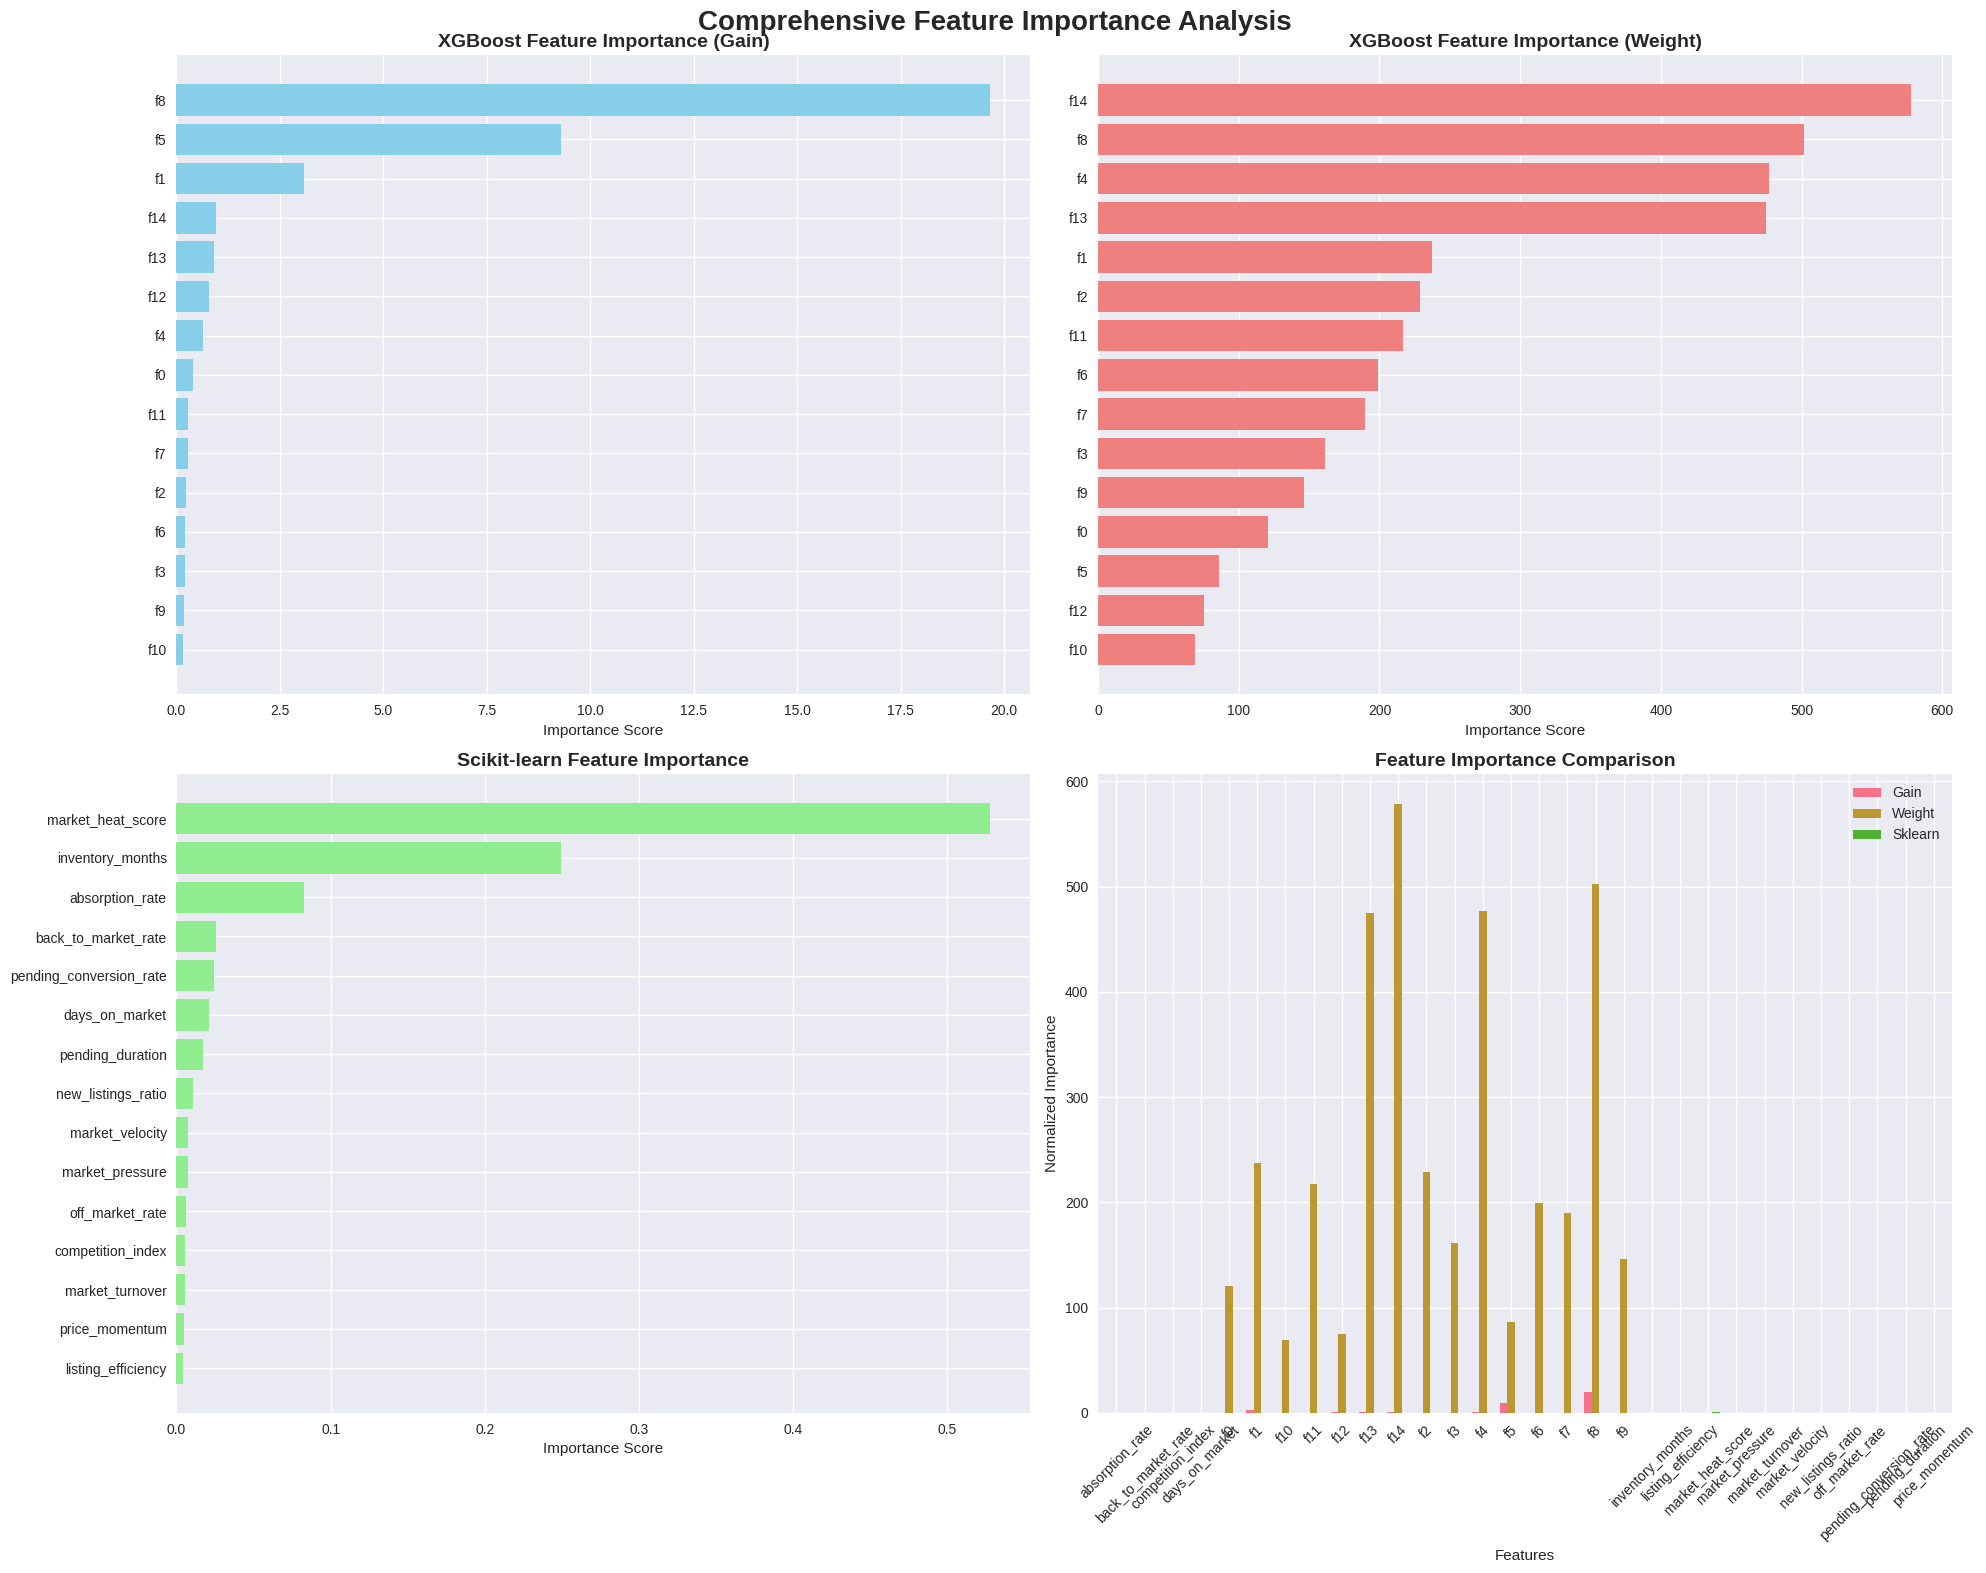


2️⃣ Feature Distributions by Market Type


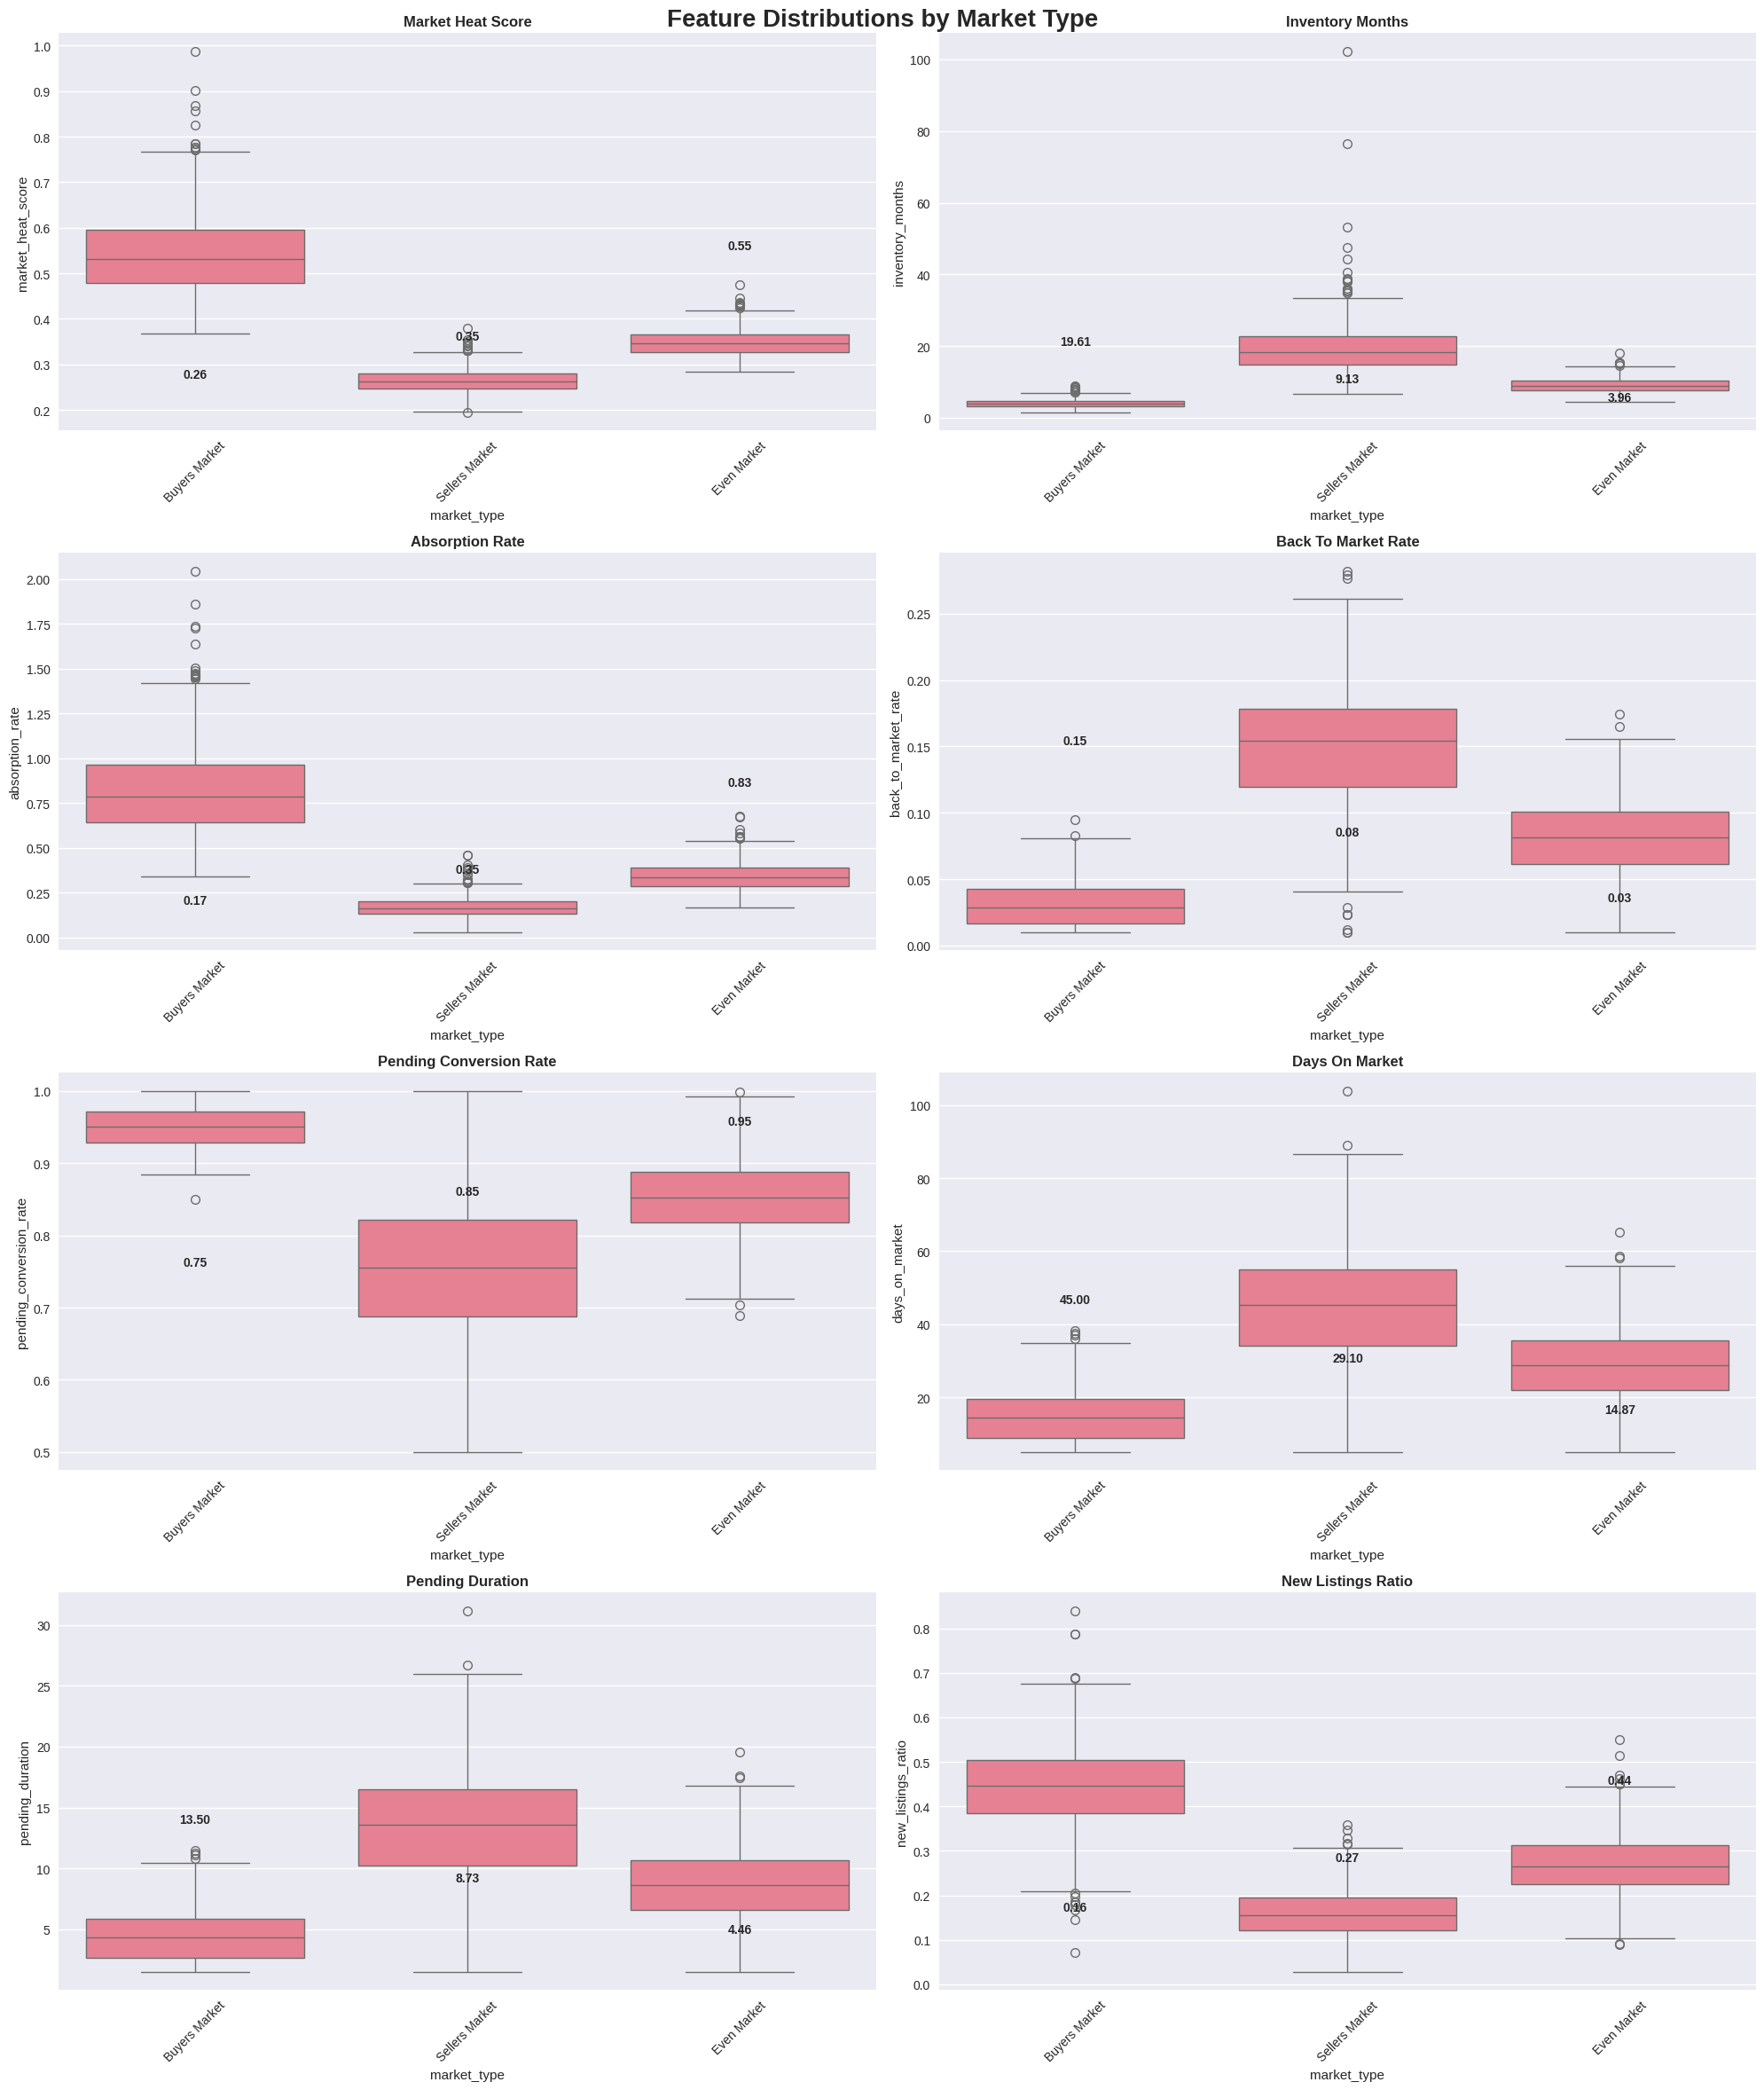


3️⃣ Correlation Analysis


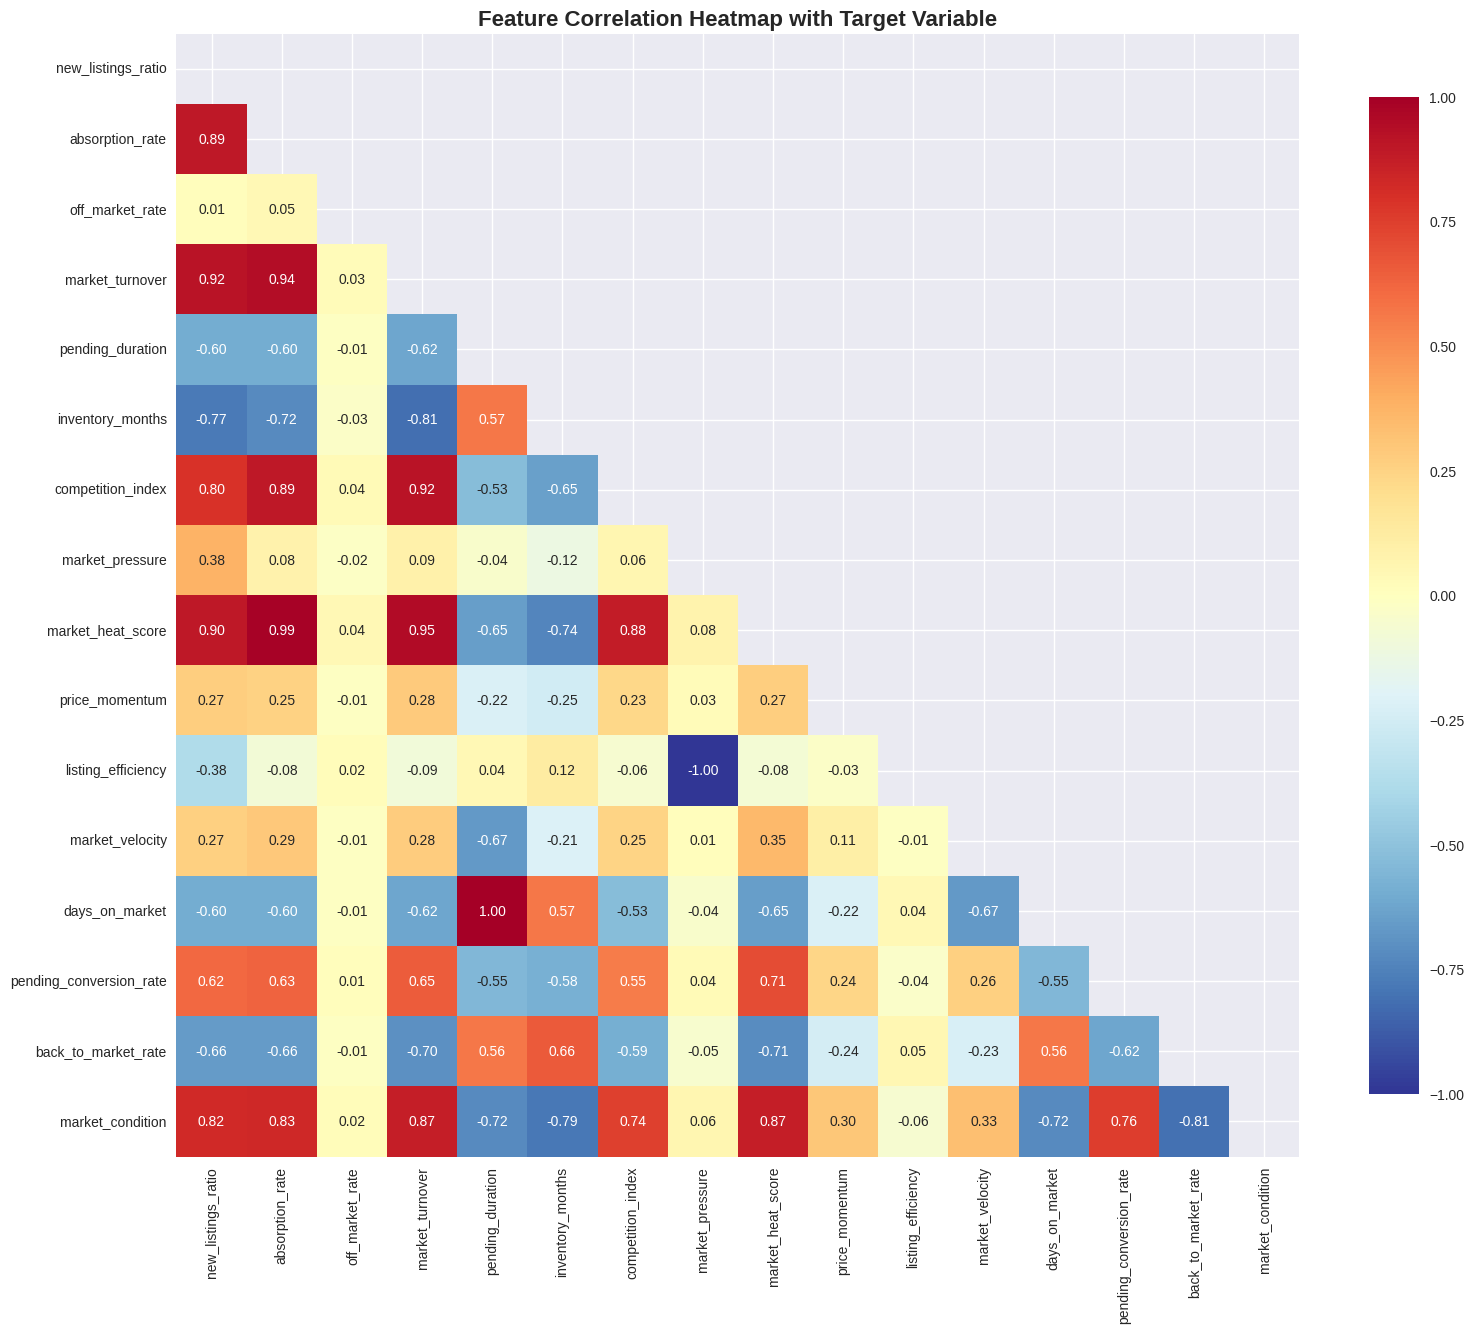

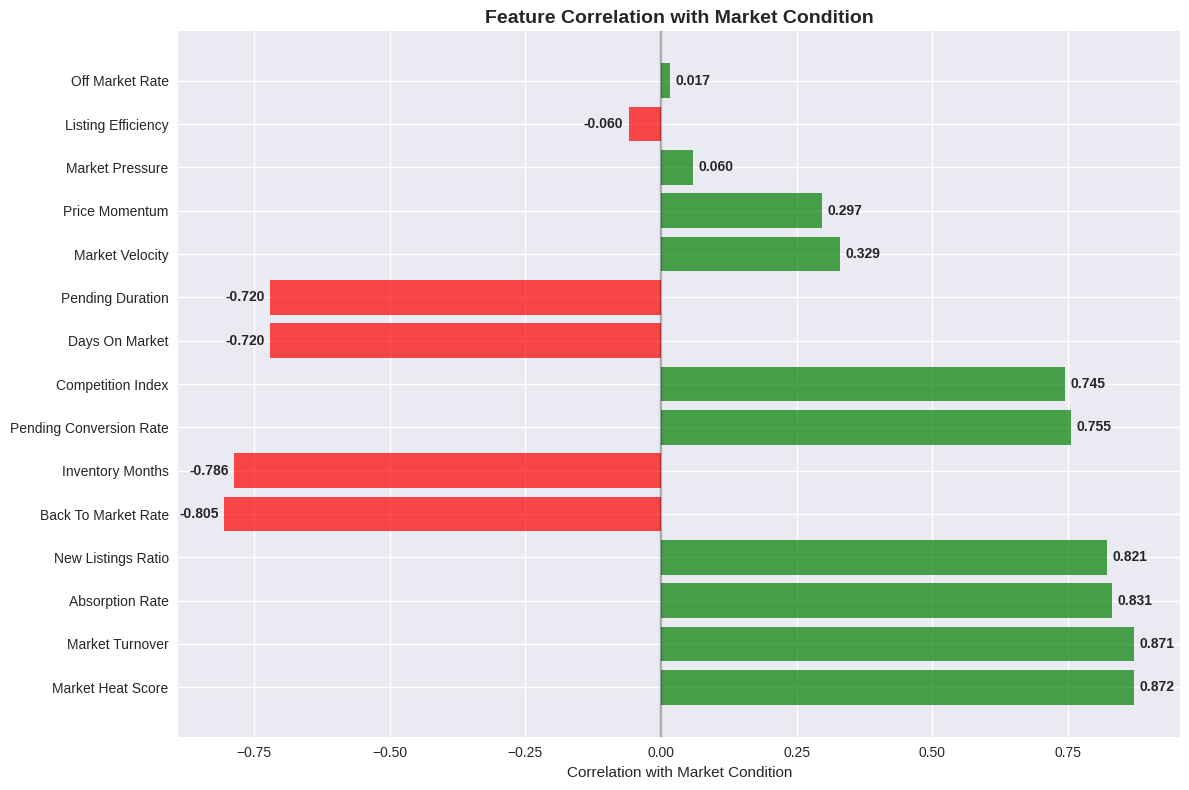


4️⃣ Partial Dependence Analysis


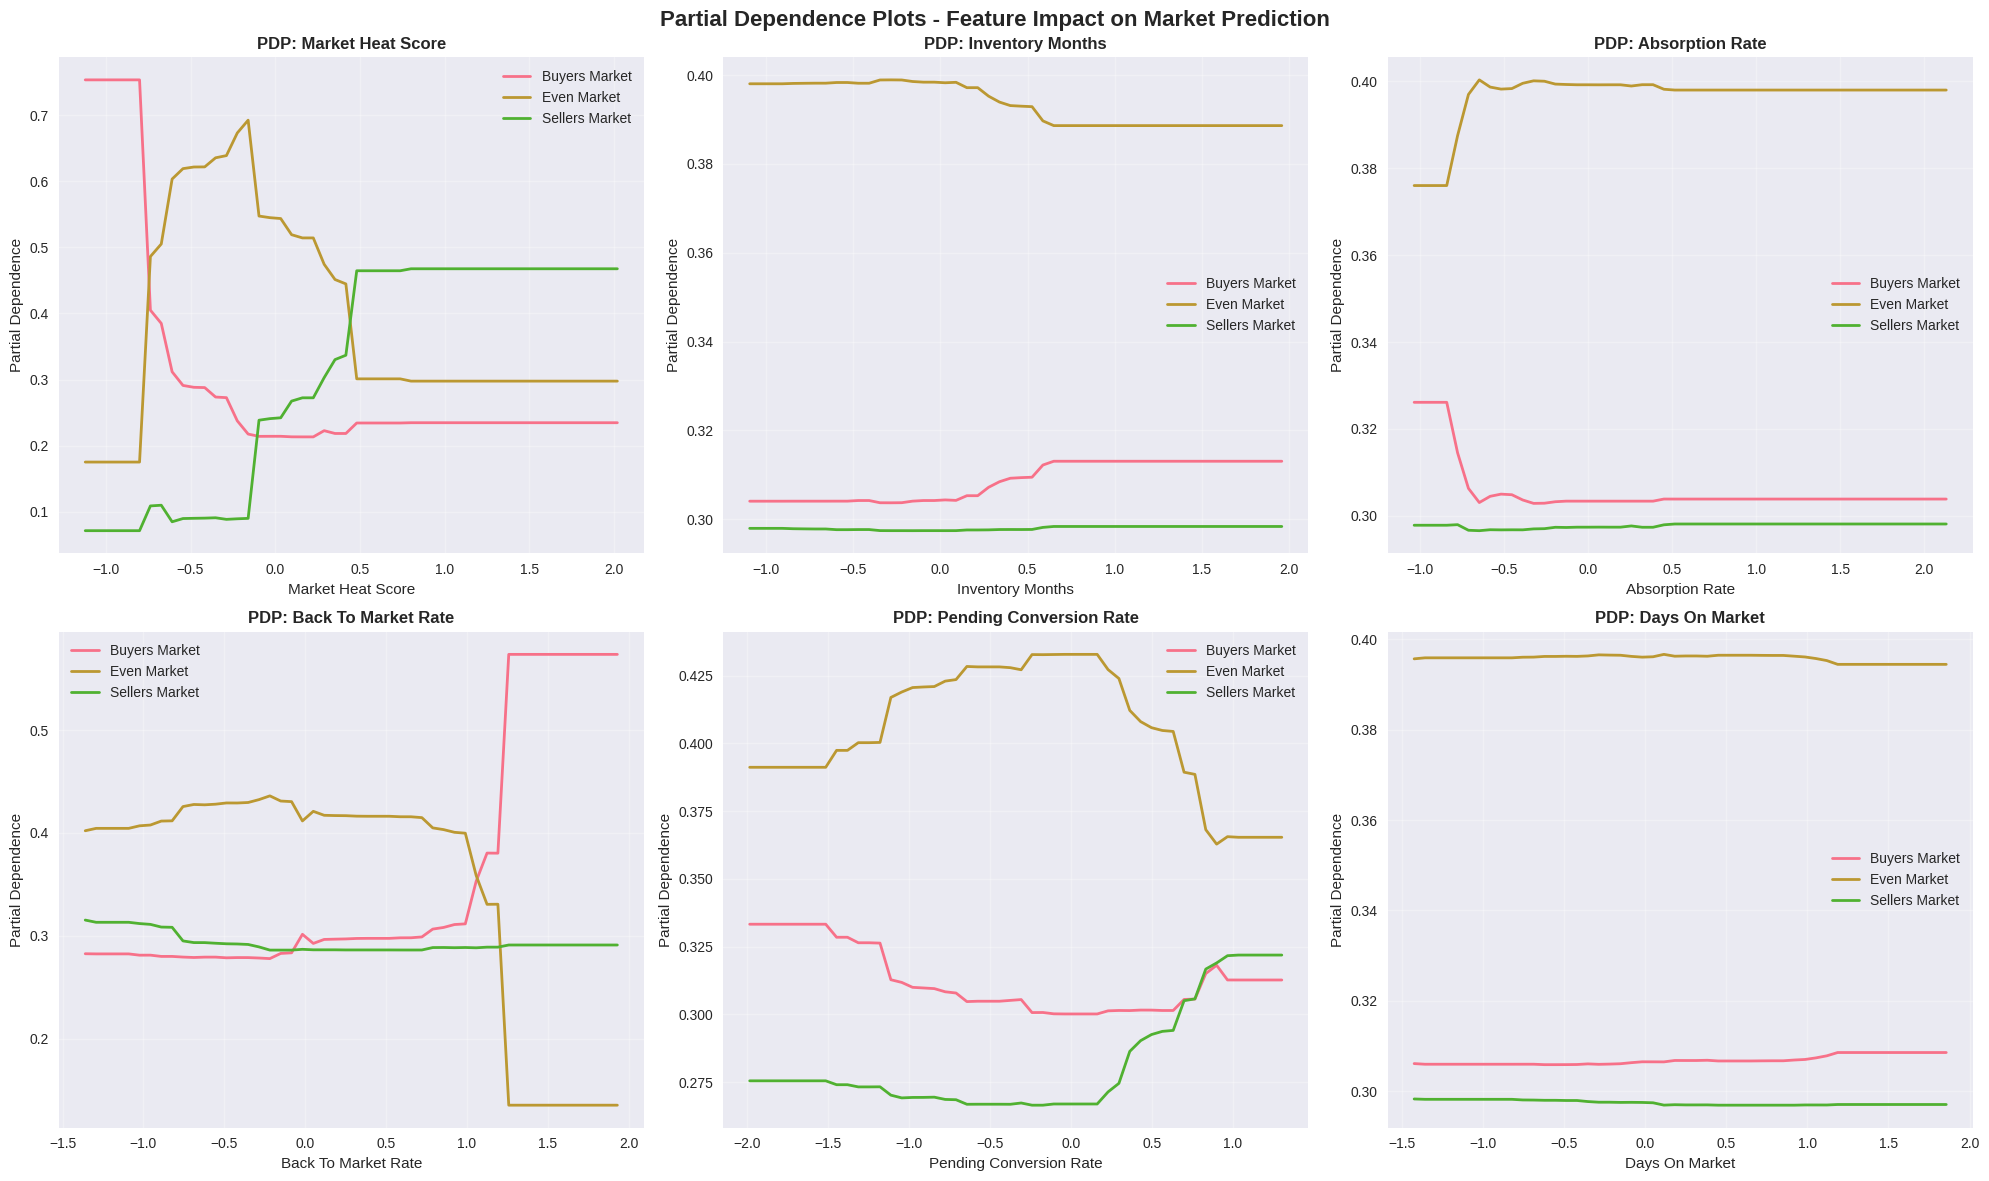


5️⃣ Feature Interaction Analysis


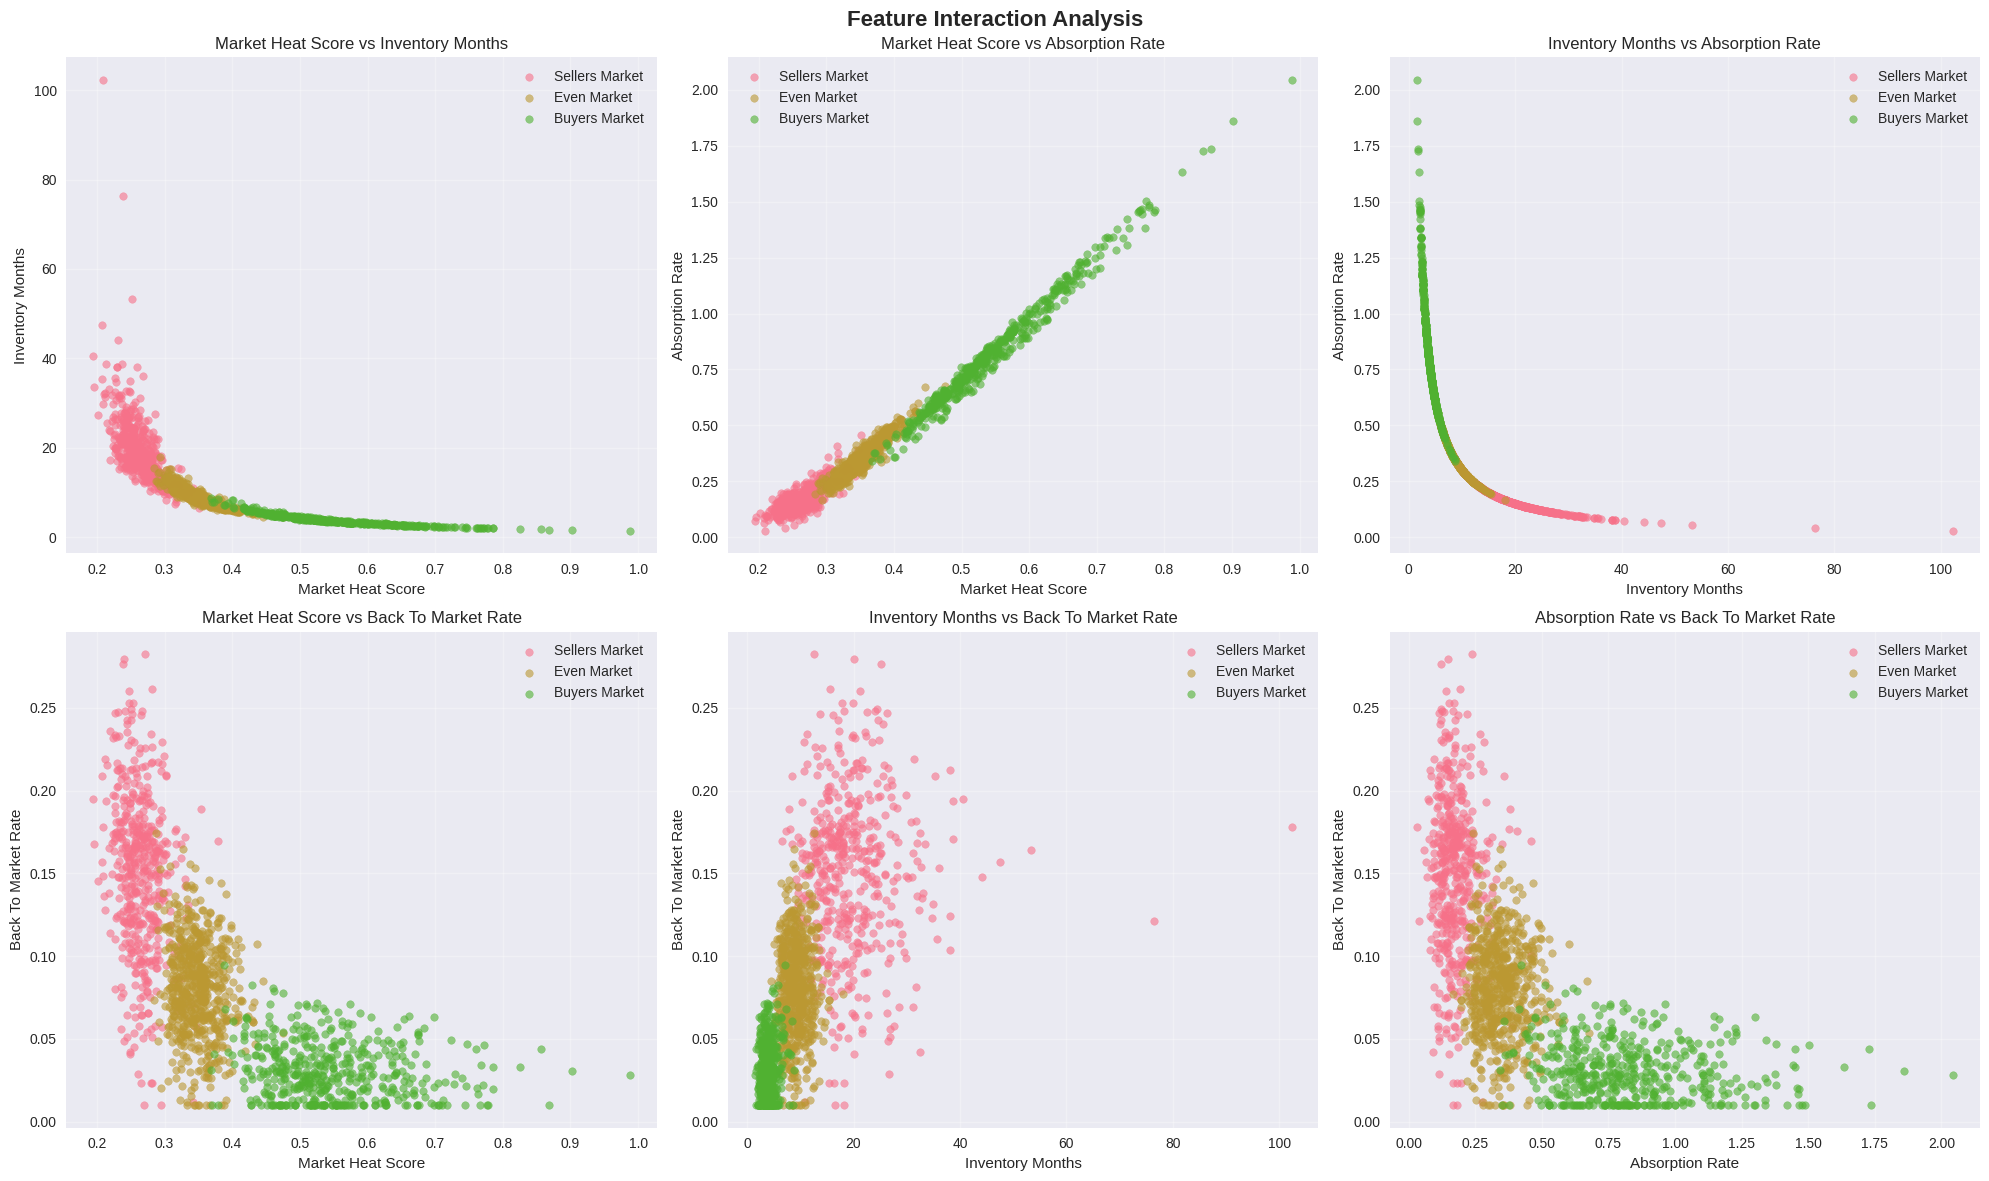


📋 KEY INSIGHTS SUMMARY

🏆 Top 3 Most Important Features:
   1. Market Heat Score: 0.5275
   2. Inventory Months: 0.2492
   3. Absorption Rate: 0.0827

📈 Strongest Positive Correlations with Market Condition:
   • Market Heat Score: 0.872
   • Market Turnover: 0.871
   • Absorption Rate: 0.831

📉 Strongest Negative Correlations with Market Condition:
   • Days On Market: -0.720
   • Pending Duration: -0.720
   • Listing Efficiency: -0.060

7️⃣ Model Performance Evaluation
✅ Final Model Accuracy: 0.9800
✅ Total Features Analyzed: 15
✅ Training Samples: 1600
✅ Test Samples: 400

🎉 Comprehensive Feature-Target Analysis Completed Successfully!


In [30]:
# Enhanced main function with comprehensive analysis
def main_enhanced():
    """
    Complete example with comprehensive feature-target relationship analysis
    """
    print("🏡 Enhanced Housing Market Prediction with Feature Analysis")
    print("=" * 60)

    # Initialize the enhanced predictor
    predictor = EnhancedHousingMarketPredictor()

    # Generate sample data
    print("📊 Generating sample housing market data...")
    raw_data = predictor.create_sample_data(n_samples=2000)

    # Engineer features
    print("🔧 Engineering features...")
    featured_data = predictor.engineer_features(raw_data)

    # Prepare features and target
    X = predictor.prepare_features(featured_data)
    y = featured_data['market_condition']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train model
    predictor.fit(X_train, y_train, optimize_hyperparameters=False)

    # Generate comprehensive analysis
    analysis_results = predictor.create_comprehensive_analysis_report()

    # Model evaluation
    print("\n7️⃣ Model Performance Evaluation")
    y_pred = predictor.model.predict(predictor.scaler.transform(X_test))
    accuracy = accuracy_score(y_test, y_pred)

    print(f"✅ Final Model Accuracy: {accuracy:.4f}")
    print(f"✅ Total Features Analyzed: {len(predictor.feature_names)}")
    print(f"✅ Training Samples: {len(X_train)}")
    print(f"✅ Test Samples: {len(X_test)}")

    return predictor, analysis_results

if __name__ == "__main__":
    # Run the enhanced analysis
    model, results = main_enhanced()
    print("\n🎉 Comprehensive Feature-Target Analysis Completed Successfully!")
